In [1]:
import random
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def preprocess_train(tensor):
    tensor -= tensor.mean().item()
    tensor = F.pad(tensor, pad=(4, 4, 4, 4), mode='constant', value=0)
    t = random.randrange(8)
    l = random.randrange(8)
    tensor = tensor[:, t:t+32, l:l+32]
    if random.random() < 0.5:
        tensor = transforms.functional.hflip(tensor)

    return tensor


def preprocess_test(tensor):
    tensor -= tensor.mean().item()
    return tensor


def get_dataloader(is_train, batch_size, path):
    if is_train:
        return DataLoader(
            datasets.CIFAR10(path,
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(preprocess_train)
                            ])),
            batch_size=batch_size,
            shuffle=True
        )
    else:
        return DataLoader(
            datasets.CIFAR10(path,
                            train=False,
                            download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(preprocess_test)
                            ])),
            batch_size=batch_size,
            shuffle=False
        )

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResNetCifarBlock(nn.Module):
    def __init__(self, input_nc, output_nc):
        super().__init__()
        stride = 1
        self.expand = False
        if input_nc != output_nc:
            assert input_nc * 2 == output_nc, 'output_nc must be input_nc * 2'
            stride = 2
            self.expand = True

        self.conv1 = nn.Conv2d(input_nc, output_nc, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_nc)
        self.conv2 = nn.Conv2d(output_nc, output_nc, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output_nc)

    def forward(self, x):
        xx = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = self.bn2(self.conv2(xx))
        if self.expand:
            x = F.interpolate(x, scale_factor=0.5, mode='nearest')  # subsampling
            zero = torch.zeros_like(x)
            x = torch.cat([x, zero], dim=1)  # option A in the original paper
        h = F.relu(y + x, inplace=True)
        return h


def make_resblock_group(cls, input_nc, output_nc, n):
    blocks = []
    blocks.append(cls(input_nc, output_nc))
    for _ in range(1, n):
        blocks.append(cls(output_nc, output_nc))
    return nn.Sequential(*blocks)


class ResNetCifar(nn.Module):
    def __init__(self, n):
        super().__init__()

        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.block1 = make_resblock_group(ResNetCifarBlock, 16, 16, n)
        self.block2 = make_resblock_group(ResNetCifarBlock, 16, 32, n)
        self.block3 = make_resblock_group(ResNetCifarBlock, 32, 64, n)
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))  # global average pooling
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)), inplace=True)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

def init_weights(net, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)


class ResNetModel:
    def __init__(self, opt, train=True):
        self.net = ResNetCifar(opt.n)
        if train:
            self.net.train()
        else:
            self.net.eval()
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            self.net = self.net.to('cuda')
            self.net = torch.nn.DataParallel(self.net)
        else:
            self.device = torch.device('cpu')

        init_weights(self.net)
        num_params = 0
        for param in self.net.parameters():
            num_params += param.numel()
        print(f'Total number of parameters : {num_params / 1e6:.3f} M')

        if train:
            self.checkpoint_dir = opt.checkpoint_dir
            self.optimizer = optim.SGD(
                self.net.parameters(),
                lr=opt.lr,
                momentum=opt.momentum,
                weight_decay=opt.weight_decay
                )
            self.scheduler = optim.lr_scheduler.MultiStepLR(
                self.optimizer,
                milestones=[opt.decay_lr_1, opt.decay_lr_2],
                gamma=opt.lr_decay_rate
                )
            self.criterion = nn.CrossEntropyLoss()
            self.loss = 0.0

    def optimize_params(self, x, label):
        x = x.to(self.device)
        label = label.to(self.device)
        y = self._forward(x)
        self._update_params(y, label)

    def _forward(self, x):
        return self.net(x)

    def _backward(self, y, label):
        self.loss = self.criterion(y, label)
        self.loss.backward()

    def _update_params(self, y, label):
        self.optimizer.zero_grad()
        self._backward(y, label)
        self.optimizer.step()
        self.scheduler.step()  # scheduler step in each iteration

    def test(self, x, label):
        with torch.no_grad():
            x = x.to(self.device)
            label = label.to(self.device)
            outputs = self._forward(x)
            _, predicted = torch.max(outputs.data, 1)
            total = label.size(0)
            correct = (predicted == label).sum().item()
            return correct, total, predicted

    def val(self, x, label):
        with torch.no_grad():
            x = x.to(self.device)
            label = label.to(self.device)
            y = self._forward(x)
            return self.criterion(y, label).item()

    def save_model(self, name):
        path = os.path.join(self.checkpoint_dir, f'model_{name}.pth')
        torch.save(self.net.state_dict(), path)
        print(f'model saved to {path}')

    def load_model(self, path):
        self.net.load_state_dict(torch.load(path))
        print(f'model loaded from {path}')

    def get_current_loss(self):
        return self.loss.item()

In [4]:
import os, time, argparse
import torch, torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# Function to evaluate test performance.
def evaluate_model(model, test_loader):
    model.net.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            outputs = model.net(inputs)
            loss = model.criterion(outputs, labels).item()
            total_loss += loss * inputs.size(0)
            count += inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / count
    return np.array(all_preds), np.array(all_labels), avg_loss

# Custom experiment runner.
def run_experiment(exp_name, optimizer_type, lr, momentum, weight_decay, n_iter=64000, print_freq=10):
    # Build configuration using argparse.Namespace.
    opt = argparse.Namespace(
        n=3,
        batch=128,
        dataset_dir='./dataset',
        checkpoint_dir=f'./checkpoint_{exp_name}',
        print_freq=print_freq,
        save_params_freq=1000,
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay,
        decay_lr_1=32000,
        decay_lr_2=48000,
        lr_decay_rate=0.1,
        n_iter=n_iter
    )
    os.makedirs(opt.checkpoint_dir, exist_ok=True)
    
    # Initialize model.
    model = ResNetModel(opt, train=True)
    if optimizer_type.lower() == 'adam':
        model.optimizer = optim.Adam(model.net.parameters(), lr=lr, weight_decay=weight_decay)
        # If desired, disable scheduler for Adam:
        # model.scheduler = None  
    
    # Lists to record training loss over iterations.
    iter_list = []
    train_loss_list = []
    test_loss_list = []
    accuracy_list = []
    
    start_time = time.time()
    total_iter = 0
    loss_sum = 0.0
    train_loader = get_dataloader(True, opt.batch, opt.dataset_dir)
    test_loader = get_dataloader(False, opt.batch, opt.dataset_dir)
    
    print(f"Starting {exp_name}...")
    # Training loop.
    while total_iter < opt.n_iter:
        for inputs, labels in train_loader:
            total_iter += 1
            model.optimize_params(inputs, labels)
            loss_sum += model.get_current_loss()
            if total_iter % print_freq == 0:
                
                avg_loss = loss_sum / print_freq
                preds, labels, test_loss = evaluate_model(model, test_loader)
                test_accuracy  = accuracy_score(labels, preds) * 100
                # print(f'{exp_name} iter {total_iter}: avg train loss = {avg_loss:.4f} test loss = {test_loss:.4f} test accuracy = {test_accuracy:.4f}')
                
                test_loss_list.append(test_loss)
                accuracy_list.append(test_accuracy)
                train_loss_list.append(avg_loss)
                iter_list.append(total_iter)
                
                loss_sum = 0.0
            
            if total_iter >= opt.n_iter:
                break

        
    
    training_time = time.time() - start_time
    model.save_model(f'final_{exp_name}')
    
    # Evaluate on test set.
    
    preds, labels, test_loss = evaluate_model(model, test_loader)
    test_accuracy  = accuracy_score(labels, preds) * 100
    
    preds, labels, test_loss = evaluate_model(model, test_loader)
    test_accuracy  = accuracy_score(labels, preds) * 100
    test_precision = precision_score(labels, preds, average='macro', zero_division=1)
    test_recall    = recall_score(labels, preds, average='macro', zero_division=1)
    test_f1        = f1_score(labels, preds, average='macro', zero_division=1)
    cm             = confusion_matrix(labels, preds)
    
    print(f'\n=== {exp_name} Evaluation ===')
    print(f'Hyperparameters used: {vars(opt)}')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    print(f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')
    print('Confusion Matrix:')
    print(cm)
    print(f'Training time: {training_time:.2f} seconds')
    
    # Return results with hyperparameters and outputs.
    results = {
        'exp_name': exp_name,
        'optimizer_type': optimizer_type,
        'hyperparams': vars(opt),
        'iter_list': iter_list,
        'train_loss_list': train_loss_list,
        "test_loss_list": test_loss_list,
        "test_accuracy_list": accuracy_list,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'confusion_matrix': cm,
        'training_time': training_time
    }
    return results

In [5]:
results = {
    "sgd": [],
    "momentum-sgd": [],
    "adam": []
}
lr_multiplier = [1,2,5]

In [6]:

for i in range(3):
    lr = 0.01*lr_multiplier[i]
    results_sgd = run_experiment(f"sgd_lr-{lr}", optimizer_type="sgd", lr=lr, momentum=0.0, weight_decay=0.0001, n_iter=16000, print_freq=50)
    results["sgd"].append(results_sgd)

Total number of parameters : 0.270 M


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified
Starting sgd_lr-0.01...
model saved to ./checkpoint_sgd_lr-0.01/model_final_sgd_lr-0.01.pth

=== sgd_lr-0.01 Evaluation ===
Hyperparameters used: {'n': 3, 'batch': 128, 'dataset_dir': './dataset', 'checkpoint_dir': './checkpoint_sgd_lr-0.01', 'print_freq': 50, 'save_params_freq': 1000, 'lr': 0.01, 'momentum': 0.0, 'weight_decay': 0.0001, 'decay_lr_1': 32000, 'decay_lr_2': 48000, 'lr_decay_rate': 0.1, 'n_iter': 16000}
Test Loss: 0.7929
Test Accuracy: 72.16%
Precision: 0.7221, Recall: 0.7216, F1 Score: 0.7190
Confusion Matrix:
[[664  51  53  19   9   3   6  12 139  44]
 [  8 923   0   2   0   1   2   2  23  39]
 [ 62  17 543  97  96  44  76  33  23   9]
 [ 14  17  48 595  35 158  47  36  31  19]
 [ 18  10  38  65 644  40  67  97  18   3]
 [  5  12  34 187  45 622  14  63   9   9]
 [  6  12  33  88  41  35 758   7  17   3]
 [ 16   8  20  38  50  67   4 766   8  23]
 [ 36  31   7   9   5   5   2 

In [7]:
for i in range(3):
    lr = 0.01*lr_multiplier[i]
    results_momentum = run_experiment(f"momemntum_sgd_lr-{lr}", optimizer_type="sgd", lr=lr, momentum=0.9, weight_decay=0.0001, n_iter=16000, print_freq=50)
    results["momentum-sgd"].append(results_momentum)

Total number of parameters : 0.270 M
Files already downloaded and verified
Files already downloaded and verified
Starting momemntum_sgd_lr-0.01...
model saved to ./checkpoint_momemntum_sgd_lr-0.01/model_final_momemntum_sgd_lr-0.01.pth

=== momemntum_sgd_lr-0.01 Evaluation ===
Hyperparameters used: {'n': 3, 'batch': 128, 'dataset_dir': './dataset', 'checkpoint_dir': './checkpoint_momemntum_sgd_lr-0.01', 'print_freq': 50, 'save_params_freq': 1000, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'decay_lr_1': 32000, 'decay_lr_2': 48000, 'lr_decay_rate': 0.1, 'n_iter': 16000}
Test Loss: 0.5214
Test Accuracy: 83.24%
Precision: 0.8470, Recall: 0.8324, F1 Score: 0.8349
Confusion Matrix:
[[878   3  12  25  14   3   9   2  49   5]
 [ 11 897   1  11   0   6   8   0  33  33]
 [ 72   1 648 113  61  47  44   7   6   1]
 [ 13   0  11 806  28  91  34   4   8   5]
 [  6   1  22  89 826  15  24  13   3   1]
 [  4   0  13 180  23 766   7   6   0   1]
 [  6   0  14  76  17   8 875   0   4   0]
 [ 14

In [8]:
for i in range(3):
    lr = 0.01*lr_multiplier[i]
    results_adam = run_experiment(f"adam_lr-{lr}", optimizer_type="adam", lr=lr, momentum=0.0, weight_decay=0.0001, n_iter=16000, print_freq=50)
    results["adam"].append(results_adam)


Total number of parameters : 0.270 M
Files already downloaded and verified
Files already downloaded and verified
Starting adam_lr-0.01...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


model saved to ./checkpoint_adam_lr-0.01/model_final_adam_lr-0.01.pth

=== adam_lr-0.01 Evaluation ===
Hyperparameters used: {'n': 3, 'batch': 128, 'dataset_dir': './dataset', 'checkpoint_dir': './checkpoint_adam_lr-0.01', 'print_freq': 50, 'save_params_freq': 1000, 'lr': 0.01, 'momentum': 0.0, 'weight_decay': 0.0001, 'decay_lr_1': 32000, 'decay_lr_2': 48000, 'lr_decay_rate': 0.1, 'n_iter': 16000}
Test Loss: 0.6479
Test Accuracy: 77.67%
Precision: 0.7784, Recall: 0.7767, F1 Score: 0.7748
Confusion Matrix:
[[716  11  46  19  15   1   3   9 134  46]
 [  7 877   4   0   1   5   4   1  15  86]
 [ 51   1 698  33  80  32  46  22  24  13]
 [ 13   3  75 592  62 106  57  35  32  25]
 [ 11   1  37  31 812  18  24  42  19   5]
 [  3   2  60 146  47 645  21  52  12  12]
 [  8   4  42  31  60  14 810  12  17   2]
 [ 12   2  23  40  66  16   5 793  19  24]
 [ 30  17   7   4   1   1   3   1 919  17]
 [  9  34   3   5   1   2   2   4  35 905]]
Training time: 1429.49 seconds
Total number of parameters 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


model saved to ./checkpoint_adam_lr-0.02/model_final_adam_lr-0.02.pth

=== adam_lr-0.02 Evaluation ===
Hyperparameters used: {'n': 3, 'batch': 128, 'dataset_dir': './dataset', 'checkpoint_dir': './checkpoint_adam_lr-0.02', 'print_freq': 50, 'save_params_freq': 1000, 'lr': 0.02, 'momentum': 0.0, 'weight_decay': 0.0001, 'decay_lr_1': 32000, 'decay_lr_2': 48000, 'lr_decay_rate': 0.1, 'n_iter': 16000}
Test Loss: 0.8910
Test Accuracy: 68.05%
Precision: 0.7125, Recall: 0.6805, F1 Score: 0.6761
Confusion Matrix:
[[672  34  70  26  13   0   8  12  86  79]
 [  8 857   2   8   0   1   8   1  14 101]
 [ 76   8 479 163  71  31  94  43  14  21]
 [ 16   9  30 753  27  32  49  39  18  27]
 [ 25   4  57 141 542   4  88 117   7  15]
 [  6   6  38 494  35 309  18  75   5  14]
 [  7   6  32 158  19   1 751   4  16   6]
 [ 13   8  14  99  28  10  10 777   4  37]
 [ 77  54   6  24   1   0   6   4 766  62]
 [ 12  49   2  16   1   0   0   6  15 899]]
Training time: 1450.36 seconds
Total number of parameters 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


model saved to ./checkpoint_adam_lr-0.05/model_final_adam_lr-0.05.pth

=== adam_lr-0.05 Evaluation ===
Hyperparameters used: {'n': 3, 'batch': 128, 'dataset_dir': './dataset', 'checkpoint_dir': './checkpoint_adam_lr-0.05', 'print_freq': 50, 'save_params_freq': 1000, 'lr': 0.05, 'momentum': 0.0, 'weight_decay': 0.0001, 'decay_lr_1': 32000, 'decay_lr_2': 48000, 'lr_decay_rate': 0.1, 'n_iter': 16000}
Test Loss: 1.2755
Test Accuracy: 53.53%
Precision: 0.5329, Recall: 0.5353, F1 Score: 0.5246
Confusion Matrix:
[[518  85  84  12  35   9   7  39 145  66]
 [ 20 705   2   5  10   1   1  13  26 217]
 [100  14 260  44 264 122  89  69  20  18]
 [ 17  22  65 200 119 307  78 107  18  67]
 [ 32   8  59  28 548  37  82 173  11  22]
 [  8  19  45 146 119 453  33 145   7  25]
 [  4   6  48  51 196  48 581  21  13  32]
 [ 16   6  22  20 115 100   7 664   1  49]
 [129  83  15  18  16   6  12   6 643  72]
 [ 15 121   2   5  17   1   1  20  37 781]]
Training time: 1456.67 seconds


In [9]:
# import json
# with open("results.json", "w") as file:
#     json.dump(results, file, indent=4)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_curve(results, type_):
    plt.figure(figsize=(10, 6))
    
    for opt_type, experiments in results.items():
        for exp in experiments:
            if 'iter_list' not in exp or len(exp['iter_list']) == 0:
                print(f"Warning: Missing or empty iter_list for {opt_type} {exp.get('exp_name', '')}")
                continue
            
            if type_ == "train":
                if 'train_loss_list' in exp and len(exp['train_loss_list']) == len(exp['iter_list']):
                    plt.plot(exp['iter_list'], exp['train_loss_list'], linestyle='-', 
                             label=f"{opt_type.upper()} {exp['exp_name']}")
                else:
                    print(f"Warning: Missing or mismatched train loss data for {opt_type} {exp.get('exp_name', '')}")

            elif type_ == "test":
                if 'test_loss_list' in exp and len(exp['test_loss_list']) == len(exp['iter_list']):
                    plt.plot(exp['iter_list'], exp['test_loss_list'], linestyle='-', 
                             label=f"{opt_type.upper()} {exp['exp_name']}")
                else:
                    print(f"Warning: Missing or mismatched test loss data for {opt_type} {exp.get('exp_name', '')}")

            elif type_ == "acc":
                if 'test_accuracy_list' in exp and len(exp['test_accuracy_list']) == len(exp['iter_list']):
                    plt.plot(exp['iter_list'], exp['test_accuracy_list'], linestyle='-', 
                             label=f"{opt_type.upper()} {exp['exp_name']}")
                else:
                    print(f"Warning: Missing or mismatched accuracy data for {opt_type} {exp.get('exp_name', '')}")
    
    plt.xlabel("Iterations")
    plt.ylabel("Train Loss" if type_ == "train" else "Test Loss" if type_ == "test" else "Accuracy")
    plt.legend(title="Optimizer / Experiment", fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_conf_matrix(results):
    """
    Creates a 3x3 grid of confusion matrices.
    Each row corresponds to one optimizer type (sgd, momentum-sgd, adam) and
    each column corresponds to one experiment (assumed to be distinct learning rates).
    """
    optimizer_types = list(results.keys())
    num_opts = len(optimizer_types)
    # Assuming each optimizer has 3 experiments. Adjust the grid if needed.
    fig, axes = plt.subplots(num_opts, 3, figsize=(12, 4 * num_opts))
    
    for row_idx, opt_type in enumerate(optimizer_types):
        experiments = sorted(results[opt_type], key=lambda r: r['hyperparams']['lr'])
        for col_idx in range(3):
            ax = axes[row_idx, col_idx] if num_opts > 1 else axes[col_idx]
            if col_idx < len(experiments):
                cm = experiments[col_idx]['confusion_matrix']
                im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                ax.set_title(f"{opt_type.upper()} - LR {experiments[col_idx]['hyperparams']['lr']}")
                ax.set_xlabel("Predicted")
                ax.set_ylabel("True")
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                ax.axis('off')
    plt.tight_layout()
    plt.show()


import pandas as pd

def get_eval_metrics_df(results):
    rows = []
    for opt_type, experiments in results.items():
        experiments = sorted(experiments, key=lambda r: r['hyperparams']['lr'])
        for exp in experiments:
            hp = exp['hyperparams']
            rows.append({
                "Optimizer": opt_type.upper(),
                "Exp Name": exp['exp_name'],
                "LR": hp['lr'],
                "Test Loss": exp.get('test_loss', float('nan')),
                "Test Accuracy (%)": exp.get('test_accuracy', float('nan')),
                "Precision": exp.get('precision', float('nan')),
                "Recall": exp.get('recall', float('nan')),
                "F1": exp.get('f1', float('nan')),
                "Training Time (sec)": exp.get('training_time', float('nan'))
            })
    
    df = pd.DataFrame(rows)
    df.sort_values(by=["Optimizer", "LR"], inplace=True)

    # Handle NaNs
    df.fillna(0, inplace=True)  # Replace NaNs with 0 or any placeholder
    return df

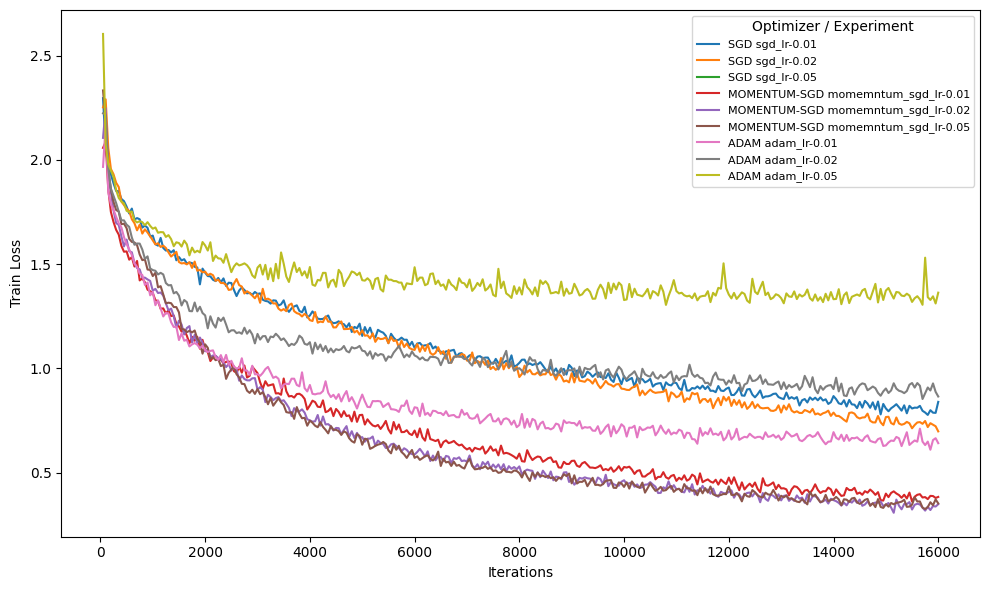

In [11]:
plot_curve(results, "train")

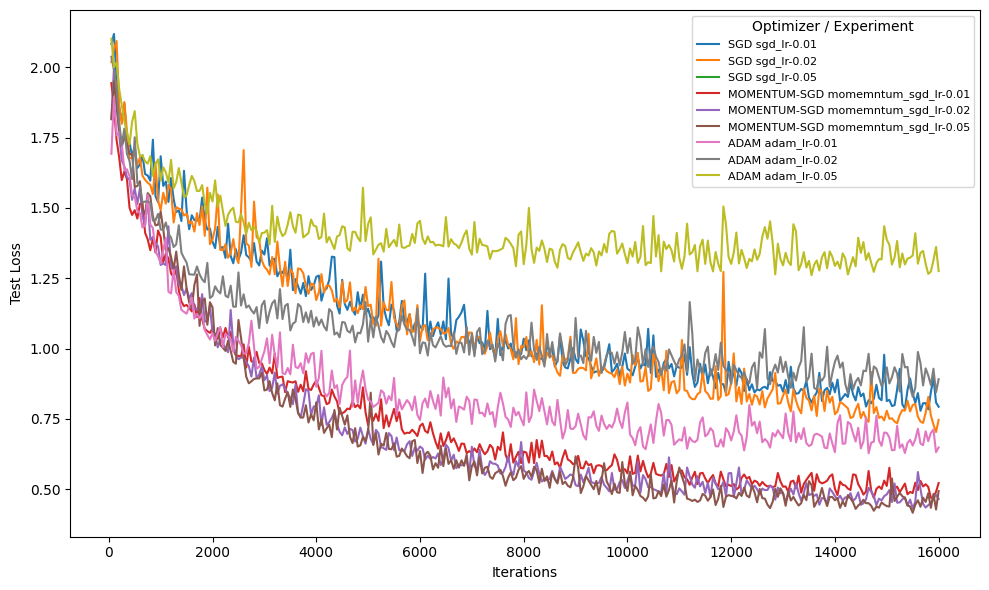

In [12]:
plot_curve(results, "test")

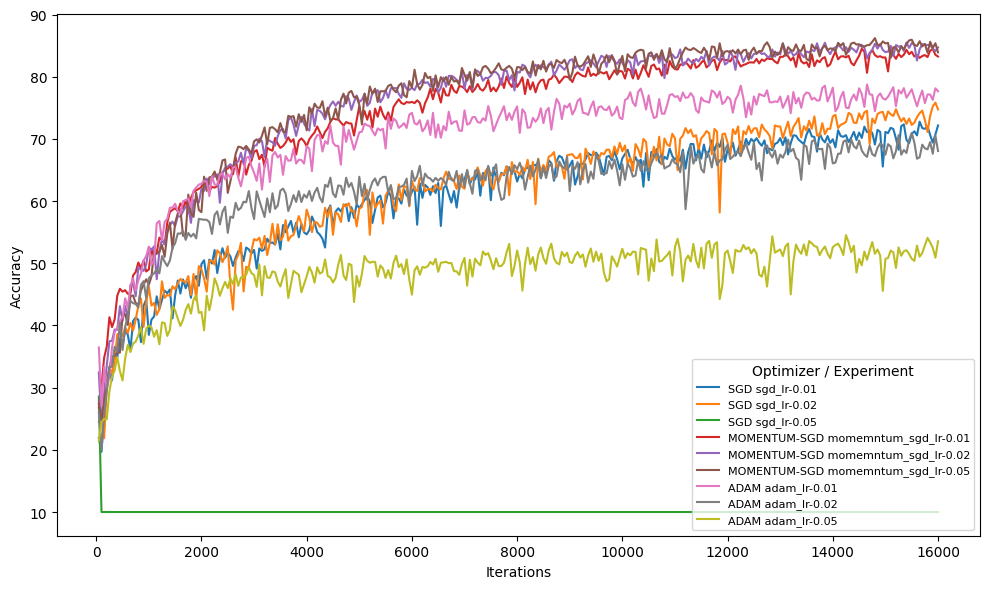

In [13]:
plot_curve(results, "acc")

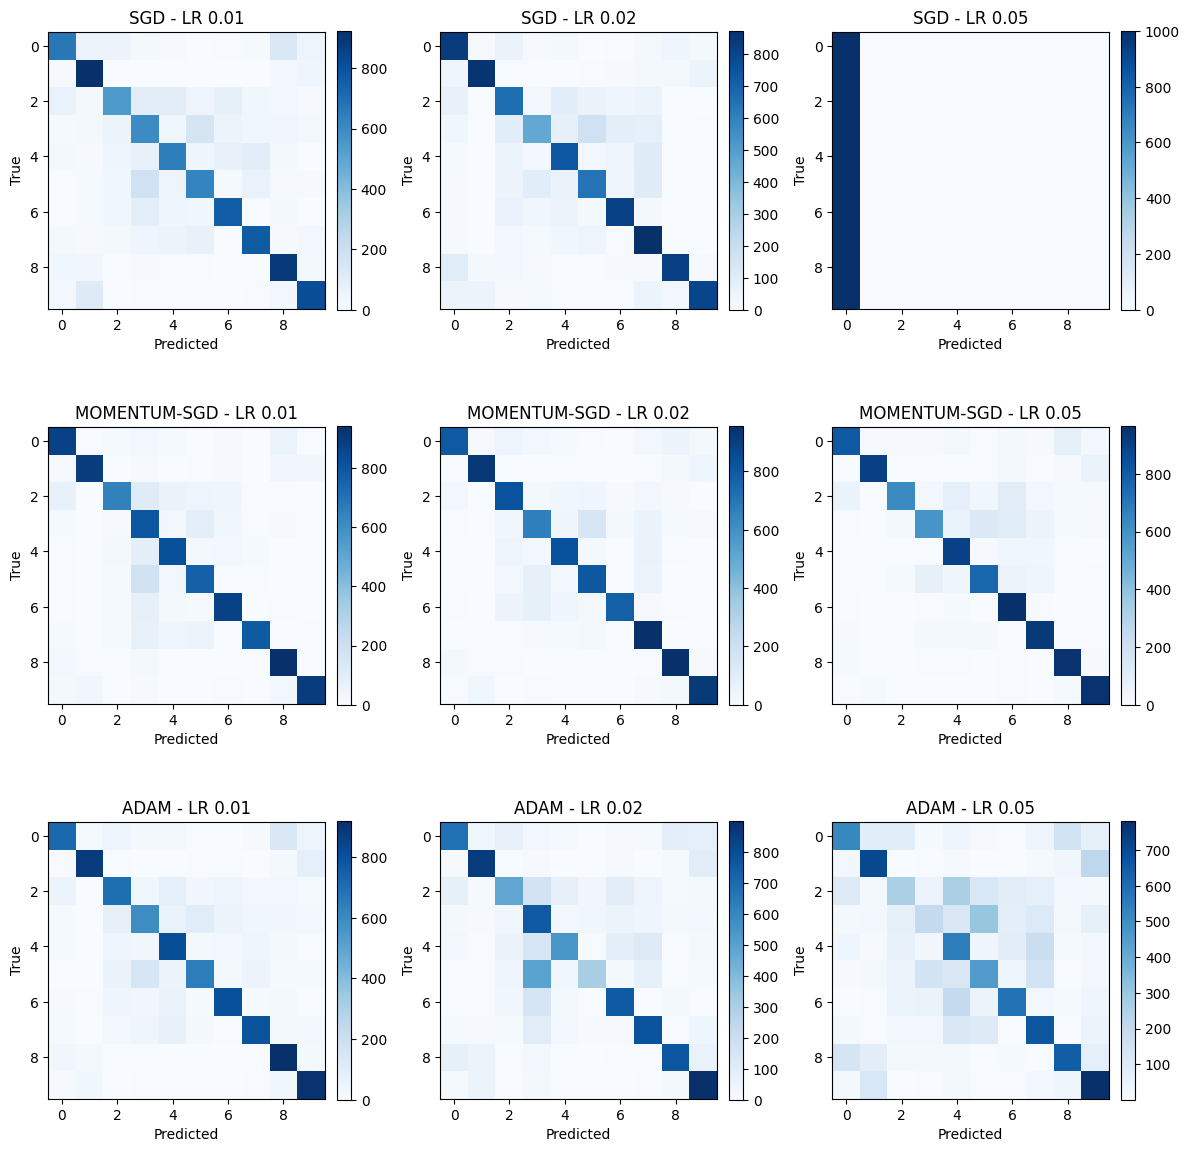

In [14]:
plot_conf_matrix(results)

In [15]:
get_eval_metrics_df(results)

,Optimizer,Exp Name,LR,Test Loss,Test Accuracy (%),Precision,Recall,F1,Training Time (sec)
6,ADAM,adam_lr-0.01,0.01,0.647912,77.67,0.778376,0.7767,0.774763,1429.490201
7,ADAM,adam_lr-0.02,0.02,0.891028,68.05,0.712494,0.6805,0.676070,1450.358588
8,ADAM,adam_lr-0.05,0.05,1.275511,53.53,0.532862,0.5353,0.524637,1456.670676
3,MOMENTUM-SGD,momemntum_sgd_lr-0.01,0.01,0.521392,83.24,0.846992,0.8324,0.834880,1427.308517
4,MOMENTUM-SGD,momemntum_sgd_lr-0.02,0.02,0.464875,84.71,0.850826,0.8471,0.846484,1442.084264
5,MOMENTUM-SGD,momemntum_sgd_lr-0.05,0.05,0.493074,83.91,0.845410,0.8391,0.835019,1477.955655
0,SGD,sgd_lr-0.01,0.01,0.792862,72.16,0.722142,0.7216,0.718988,1432.624874
1,SGD,sgd_lr-0.02,0.02,0.746295,74.74,0.752884,0.7474,0.745417,1427.470805
2,SGD,sgd_lr-0.05,0.05,0.000000,10.00,0.910000,0.1000,0.018182,1428.628356
